# Why hot things glow Ft. Planck's Law

Throughout your life, you have probably noticed that really hot objects glow.  Whether it be an incandescent lightbulb, a stovetop, running lava, and the sun. Why do hot objects glow?  The atoms and molecules that make up objects carry this heat in the form of kinetic energy and vibration.  Atoms are comprised of charged particles like protons and electrons.  When charged particles move, they interact with electromagnetic field - creating ripples known as photons.  This phenomenon is the reason we all exist.  Without the hot, vibrating, glowy atoms of the sun, life as we know it would be impossible.

<table><tr>
<td> <img src="https://media.nationalgeographic.org/assets/photos/000/290/29094.jpg"  width="400"/> </td>
<td> <img src="https://stockarch.com/files/13/09/glowing_hotplate.jpg"  width="400"/> </td>
</tr></table>

Max Planck derived an idealized model for this behavior in the early 20th century.  Previous models, such as the Rayleigh-Jeans law, assumed a continuous output space for the energy of emitted photons.  Revolutionary for the time, Planck's derivation discretized the output space into quanta.  This model assumes that the object is a perfect emitter and perfect absorber in equilibrium. Such an idealized object is called a black-body.  The following function is Planck's law, and it states for any given temperature and wavelength, you can calculate the spectral radiance of a black-body.  Integrating over the entire wavelength space will give you the total energy output of an object of temperature T.
$$B(\lambda, T) = {2hc^2 \over \lambda^5}{1 \over e^{hc \over k_BT}-1}$$

How does this prediction function compare with the real data?  Is the sun an approximate black-body? ASTM International has provided a dataset of solar spectral data, which will be compared with Planck's law.  The data will be the extraterrestrial satellite data to minimize the interference of the earths atmosphere with the measurement of the spectrum.

In [1]:
# Imports
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import auc
from sklearn.metrics import r2_score

In [2]:
# Converts nanometers to meters for calculation
def nano(wavelength):
    return (wavelength * 1e-9)

# Planck's law function, takes a temperature in Kelvin, and wavelength in nanometers
# Output is W m-3 sr-1
def planck(temperature, wavelength):
             
    h = 6.6260700e-34 # m^2 kg s^-1 
    c = 299792458     # m s^-1
    e = 2.7182818     # natural number
    k = 1.3806485e-23 # m^2 kg s^-2 K^-1    
    
    lam = nano(wavelength)
    expr1 = (2 * h * (c**2)) / (lam**5)
    expr2 = (h * c) / (k * lam * temperature)
    return expr1 * (e**expr2 - 1)**-1

In [3]:
# Data cleaning and renaming columns
data = pd.read_excel('./data/AM0AM1_5.xls',header = 1)
data.drop(columns={'Unnamed: 4',
                   'Wavelength (nm)',
                   'Extraterrestrial W*m-2*nm-1',
                   'Direct+circumsolar W*m-2*nm-1',
                   'Global tilt  W*m-2*nm-1'},
          inplace = True)
data.set_index('Wavelength (nm).1')
data.rename(columns={'Wavelength (nm).1':'wavelength',
                     'W*m-2*nm-1':'data'},
            inplace=True)
data.dropna(inplace=True)
data = data.loc[data.wavelength <= 3000]

In [ ]:
# Normalize units for distance to earth
sun_radius = 6.957e8
au = 1.495e11
pi = 3.14159
l = (sun_radius / au) ** 2
data['model'] = [planck(5777, x) * 1e-9 * l * pi 
                 for x 
                 in data.wavelength]

The trickiest part working with this data is the units.  Our data has units of $W m^{-2} nm^{-1}$ while our predictor function has output units of $W m^{-3} sr^{-1}$ because distance from the sun to the earth has not yet been accounted for.  To normalize units, the output of our function is multiplied by nanometers, times $\pi ({R_s \over r_e})^2$

$$B_{detector} = \pi B(\lambda, T)({R_s \over r_e})^2 * 10^{-9}nm$$

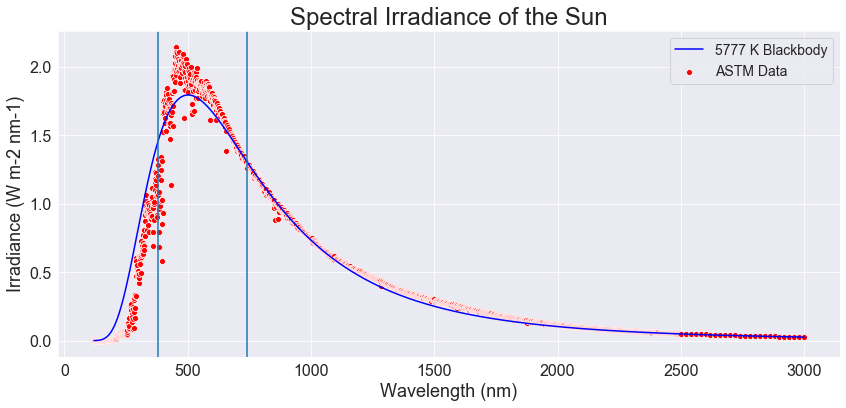

In [4]:
fig, ax = plt.subplots(figsize = (14,6))
sns.scatterplot(data.wavelength,
                data.data, color = 'red');
sns.lineplot(data.wavelength,
                data.model, color = 'blue')
ax.set_xlabel('Wavelength (nm)',
              fontsize = 18)
ax.set_ylabel('Irradiance (W m-2 nm-1)',
              fontsize = 18)
ax.set_title('Spectral Irradiance of the Sun',
             fontsize = 24)
ax.tick_params(labelsize=16)
ax.legend(['5777 K Blackbody','ASTM Data'], prop={'size': 14});
plt.axvline(380, 0,2);
plt.axvline(740, 0,2);

In [5]:
r2_score(data.data, data.model)

0.9551676112896605

In the above graphic, the spectral irradiance of the sun is shown.  The visual spectrum is marked between 340nm and 780nm.  The blue trace is the predictor function for a temperature of 5777 Kelvin.  How does it score? Planck's Law gets an R-Squared value of ~0.95 with this set of data, indicating a very close fit.  What is significant about this?  Recall our assumption that Planck's Law assumed an ideal absorber and emitter.  This means that we can approximate the sun as a black-body.  Measuring the spectrum of other objects and stars will not yield the same results.  Some stars have elements present in their atmosphere which absorb or emit particular frequencies disproportionately.

<img src="https://skyserver.sdss.org/dr1/en/proj/advanced/spectraltypes/images/spectra1.gif"  width="600"/>

As a bonus exercise , we can integrate this curve to get the total energy per square meter the earth receives from the sun

In [6]:
print('Estimated Total Power output of sun per square meter at earth distance from sun: {}'.format(auc(data.wavelength,data.model)))
print('Measured Total Power output of sun per square meter at earth distance from sun: {}'.format(auc(data.wavelength,data.data)))

Estimated Total Power output of sun per square meter at earth distance from sun: 1338.6367658734227
Measured Total Power output of sun per square meter at earth distance from sun: 1338.9006430499999


To put that into perspective, a typical resting human has an average surface area of 1.7 meters and radiates 100 Watts of power.  This means about 22.5 people radiate as much body heat as the earth receives from the sun in a square meter area. 